In [1]:
print("teste do ambiente")

teste do ambiente


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Spark-etl").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/06 14:48:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
import requests
import tempfile

# File ID on Google Drive
file_id = '1s5WHBz59d4v8I96CSRlqR9DWTsSU6HC_'

def extractFile(file_id, chosen_name):
    """Extracts a file from Google Drive and saves the data into a PySpark DataFrame.
    
    Args:
        file_id (str): The file ID on Google Drive.
        chosen_name (str): The chosen name to assign to the DataFrame.
    
    Returns:
        pyspark.sql.DataFrame: The DataFrame containing the file data.
    """
    url = f"https://drive.google.com/uc?id={file_id}"
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raises an error for unsuccessful responses
        
        # Creating a temporary file
        with tempfile.NamedTemporaryFile(delete=False, suffix=".csv") as temp_file:
            temp_file.write(response.content)
            temp_file_path = temp_file.name
        
        # Reading the CSV file with PySpark
        df = spark.read.csv(temp_file_path, header=True)
        
        # Showing the data
        df.show()
        
        # Assigning the DataFrame to a variable with the provided name
        globals()[chosen_name] = df
        
        return df
    
    except requests.RequestException as e:
        print(f"Error accessing the file: {e}")

extractFile(file_id, 'airports')


+---+--------------------+----------------+-----------------+----+---+---+
|faa|                name|             lat|              lon| alt| tz|dst|
+---+--------------------+----------------+-----------------+----+---+---+
|04G|   Lansdowne Airport|      41.1304722|      -80.6195833|1044| -5|  A|
|06A|Moton Field Munic...|      32.4605722|      -85.6800278| 264| -5|  A|
|06C| Schaumburg Regional|      41.9893408|      -88.1012428| 801| -6|  A|
|06N|     Randall Airport|       41.431912|      -74.3915611| 523| -5|  A|
|09J|Jekyll Island Air...|      31.0744722|      -81.4277778|  11| -4|  A|
|0A9|Elizabethton Muni...|      36.3712222|      -82.1734167|1593| -4|  A|
|0G6|Williams County A...|      41.4673056|      -84.5067778| 730| -5|  A|
|0G7|Finger Lakes Regi...|      42.8835647|      -76.7812318| 492| -5|  A|
|0P2|Shoestring Aviati...|      39.7948244|      -76.6471914|1000| -5|  U|
|0S9|Jefferson County ...|      48.0538086|     -122.8106436| 108| -8|  A|
|0W3|Harford County Ai...

DataFrame[faa: string, name: string, lat: string, lon: string, alt: string, tz: string, dst: string]

In [4]:
# Rename the faa column
airports = airports.withColumnRenamed('faa','dest')

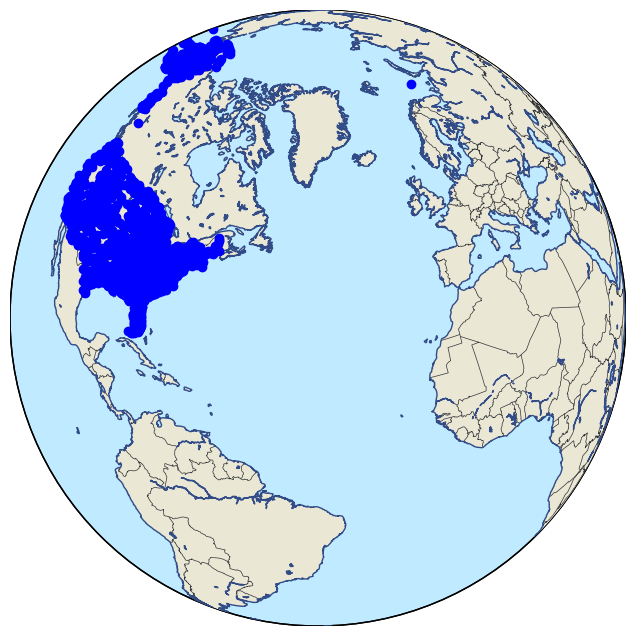

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Convert latitude and longitude columns to float
airports = airports.withColumn("lat", airports["lat"].cast("float"))
airports = airports.withColumn("lon", airports["lon"].cast("float"))

# Enable the figure and set axes and title
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1,1,1)
 
# Set the base map projection
m = Basemap(
    ax=ax,
    resolution='l',
    projection='ortho',  # Using the 'mill' projection to view the whole world
    lon_0 = -40, lat_0 = 35
    # llcrnrlon=-60, llcrnrlat=90,  # Lower left limits
    # urcrnrlon=-180, urcrnrlat=180,     # Upper right limits
)

# Set the vector layers to load as the base map
m.drawcountries(color='#303338')
m.drawmapboundary(fill_color='#c0eaff')
m.drawcoastlines(color='#324c87')
m.fillcontinents(color='#ebe7d5', lake_color='#c0eaff')

# Add markers for each airport
for row in airports.collect():
    x, y = m(row["lon"], row["lat"])  # Corrected to use m instead of mapa
    m.plot(x, y, 'bo', markersize=6)

plt.show()



In [6]:
file_id2 = "1bJ8Nguso8mQPeAE4b_tUg6N_fwH8VmnN"

extractFile(file_id2, 'flights')

+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|dest|air_time|distance|hour|minute|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|2014|   12|  8|     658|       -7|     935|       -5|     VX| N846VA|  1780|   SEA| LAX|     132|     954|   6|    58|
|2014|    1| 22|    1040|        5|    1505|        5|     AS| N559AS|   851|   SEA| HNL|     360|    2677|  10|    40|
|2014|    3|  9|    1443|       -2|    1652|        2|     VX| N847VA|   755|   SEA| SFO|     111|     679|  14|    43|
|2014|    4|  9|    1705|       45|    1839|       34|     WN| N360SW|   344|   PDX| SJC|      83|     569|  17|     5|
|2014|    3|  9|     754|       -1|    1015|        1|     AS| N612AS|   522|   SEA| BUR|     127|     937|   7|    54|
|2014|    1| 15|    1037|        7|    1

DataFrame[year: string, month: string, day: string, dep_time: string, dep_delay: string, arr_time: string, arr_delay: string, carrier: string, tailnum: string, flight: string, origin: string, dest: string, air_time: string, distance: string, hour: string, minute: string]

In [7]:
# Join the DataFrames using the "origin" column from the `flights` DataFrame and the "faa" column from the `airports` DataFrame
airports_flights = flights.join(airports, on="dest", how='leftouter')

# Display the resulting DataFrame
airports_flights.show(5)

+----+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+--------+--------+----+------+--------------------+---------+-----------+---+---+---+
|dest|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|air_time|distance|hour|minute|                name|      lat|        lon|alt| tz|dst|
+----+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+--------+--------+----+------+--------------------+---------+-----------+---+---+---+
| LAX|2014|   12|  8|     658|       -7|     935|       -5|     VX| N846VA|  1780|   SEA|     132|     954|   6|    58|    Los Angeles Intl|33.942535| -118.40807|126| -8|  A|
| HNL|2014|    1| 22|    1040|        5|    1505|        5|     AS| N559AS|   851|   SEA|     360|    2677|  10|    40|       Honolulu Intl|21.318682| -157.92242| 13|-10|  N|
| SFO|2014|    3|  9|    1443|       -2|    1652|        2|     VX| N847VA|   755|   SEA|     111|     679|  14|    43|  San 

In [8]:
from pyspark.sql.functions import count
from pyspark.sql.functions import desc

# Count the number of flights departing from each airport
departing_flights = airports_flights.groupBy("origin").agg(count("*").alias("departing_flights"))

# Count the number of flights arriving at each airport
arriving_flights = airports_flights.groupBy("dest").agg(count("*").alias("arriving_flights")).orderBy(desc("arriving_flights"))

# Display the results
print("Number of flights departing from each airport:")
departing_flights.show()

print("Number of flights arriving at each airport:")
arriving_flights.show(10)


Number of flights departing from each airport:
+------+-----------------+
|origin|departing_flights|
+------+-----------------+
|   SEA|             6754|
|   PDX|             3246|
+------+-----------------+

Number of flights arriving at each airport:
+----+----------------+
|dest|arriving_flights|
+----+----------------+
| SFO|             787|
| LAX|             615|
| DEN|             586|
| PHX|             530|
| LAS|             520|
| ANC|             449|
| ORD|             439|
| SLC|             396|
| DFW|             371|
| SJC|             369|
+----+----------------+
only showing top 10 rows



In [9]:
from pyspark.sql.functions import avg

# Calculate the average departure delay
average_departure_delay = airports_flights.agg(avg("dep_delay")).collect()[0][0]

# Calculate the average arrival delay
average_arrival_delay = airports_flights.agg(avg("arr_delay")).collect()[0][0]

# Display the results
print("Average departure delay:", round(average_departure_delay, 2), "minutes")
print("Average arrival delay:", round(average_arrival_delay, 2), "minutes")


Average departure delay: 6.07 minutes
Average arrival delay: 2.25 minutes


In [10]:
from pyspark.sql.functions import month

# Stratify delay by airport and month of the year
delay_by_airport_month = airports_flights.groupBy("month", "origin") \
    .agg(avg("dep_delay").alias("average_departure_delay"), avg("arr_delay").alias("average_arrival_delay")) \
    .orderBy("average_departure_delay", "average_arrival_delay")

# Display the results
delay_by_airport_month.show(24)


+-----+------+-----------------------+---------------------+
|month|origin|average_departure_delay|average_arrival_delay|
+-----+------+-----------------------+---------------------+
|    5|   PDX|     2.3509433962264152|  -0.3712121212121212|
|   11|   PDX|     2.8048780487804876|   -3.093877551020408|
|    3|   PDX|      2.963636363636364|  -0.8357664233576643|
|    5|   SEA|      3.388214904679376|   0.1857638888888889|
|   10|   SEA|      3.918669131238447|   0.8170055452865065|
|    4|   SEA|      4.066914498141264|  0.32710280373831774|
|    9|   SEA|      4.075862068965518|    1.389655172413793|
|    7|   PDX|      4.082802547770701| -0.22611464968152867|
|   10|   PDX|       4.14760147601476|    0.662962962962963|
|    8|   PDX|      4.493827160493828|   1.7006172839506173|
|    6|   PDX|      5.322695035460993|    1.416370106761566|
|    1|   PDX|      5.353383458646617|   0.8150943396226416|
|   11|   SEA|       5.74859287054409|   -0.543233082706767|
|    9|   PDX|      6.44

In [11]:
file_id3 = "1nWR3JWNCTByX725WU2nUaibDX70QBhpu"

extractFile(file_id3, "planes")

+-------+----+--------------------+----------------+--------+-------+-----+-----+---------+
|tailnum|year|                type|    manufacturer|   model|engines|seats|speed|   engine|
+-------+----+--------------------+----------------+--------+-------+-----+-----+---------+
| N102UW|1998|Fixed wing multi ...|AIRBUS INDUSTRIE|A320-214|      2|  182|   NA|Turbo-fan|
| N103US|1999|Fixed wing multi ...|AIRBUS INDUSTRIE|A320-214|      2|  182|   NA|Turbo-fan|
| N104UW|1999|Fixed wing multi ...|AIRBUS INDUSTRIE|A320-214|      2|  182|   NA|Turbo-fan|
| N105UW|1999|Fixed wing multi ...|AIRBUS INDUSTRIE|A320-214|      2|  182|   NA|Turbo-fan|
| N107US|1999|Fixed wing multi ...|AIRBUS INDUSTRIE|A320-214|      2|  182|   NA|Turbo-fan|
| N108UW|1999|Fixed wing multi ...|AIRBUS INDUSTRIE|A320-214|      2|  182|   NA|Turbo-fan|
| N109UW|1999|Fixed wing multi ...|AIRBUS INDUSTRIE|A320-214|      2|  182|   NA|Turbo-fan|
| N110UW|1999|Fixed wing multi ...|AIRBUS INDUSTRIE|A320-214|      2|  182|   NA

DataFrame[tailnum: string, year: string, type: string, manufacturer: string, model: string, engines: string, seats: string, speed: string, engine: string]

In [12]:
# Rename year column on panes to avoid duplicate column name
planes = planes.withColumnRenamed('year', 'plane_year')

In [13]:
#join the flights and plane table use key as tailnum column
model_data = airports_flights.join(planes, on='tailnum', how='leftouter')
model_data.show(5)

24/05/06 14:48:59 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+----+----+-----+---+--------+---------+--------+---------+-------+------+------+--------+--------+----+------+--------------------+---------+-----------+---+---+---+----------+--------------------+------------+--------+-------+-----+-----+---------+
|tailnum|dest|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|flight|origin|air_time|distance|hour|minute|                name|      lat|        lon|alt| tz|dst|plane_year|                type|manufacturer|   model|engines|seats|speed|   engine|
+-------+----+----+-----+---+--------+---------+--------+---------+-------+------+------+--------+--------+----+------+--------------------+---------+-----------+---+---+---+----------+--------------------+------------+--------+-------+-----+-----+---------+
| N846VA| LAX|2014|   12|  8|     658|       -7|     935|       -5|     VX|  1780|   SEA|     132|     954|   6|    58|    Los Angeles Intl|33.942535| -118.40807|126| -8|  A|      2011|Fixed wing multi ...|      AIRBUS|A320

In [14]:
model_data.describe()

DataFrame[summary: string, tailnum: string, dest: string, year: string, month: string, day: string, dep_time: string, dep_delay: string, arr_time: string, arr_delay: string, carrier: string, flight: string, origin: string, air_time: string, distance: string, hour: string, minute: string, name: string, lat: string, lon: string, alt: string, tz: string, dst: string, plane_year: string, type: string, manufacturer: string, model: string, engines: string, seats: string, speed: string, engine: string]

In [15]:
model_data = model_data.withColumn('arr_delay', model_data.arr_delay.cast('integer'))
model_data = model_data.withColumn('air_time' , model_data.air_time.cast('integer'))
model_data = model_data.withColumn('month', model_data.month.cast('integer'))
model_data = model_data.withColumn('plane_year', model_data.plane_year.cast('integer'))

In [16]:
model_data.describe('arr_delay', 'air_time','month', 'plane_year').show()

+-------+------------------+------------------+------------------+-----------------+
|summary|         arr_delay|          air_time|             month|       plane_year|
+-------+------------------+------------------+------------------+-----------------+
|  count|              9925|              9925|             10000|             9354|
|   mean|2.2530982367758186|152.88423173803525|            6.6438|2001.594398118452|
| stddev|31.074918600451877|  72.8656286392139|3.3191600205962097|58.92921992728455|
|    min|               -58|                20|                 1|                0|
|    max|               900|               409|                12|             2014|
+-------+------------------+------------------+------------------+-----------------+



In [17]:
# Create a new column
model_data =model_data.withColumn('plane_age', model_data.year - model_data.plane_year)

In [18]:
model_data = model_data.withColumn('is_late', model_data.arr_delay >0)

model_data = model_data.withColumn('label', model_data.is_late.cast('integer'))

model_data.filter("arr_delay is not NULL and dep_delay is not NULL and air_time is not NULL and plane_year is not NULL")

DataFrame[tailnum: string, dest: string, year: string, month: int, day: string, dep_time: string, dep_delay: string, arr_time: string, arr_delay: int, carrier: string, flight: string, origin: string, air_time: int, distance: string, hour: string, minute: string, name: string, lat: float, lon: float, alt: string, tz: string, dst: string, plane_year: int, type: string, manufacturer: string, model: string, engines: string, seats: string, speed: string, engine: string, plane_age: double, is_late: boolean, label: int]

In [19]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

#Create a StringIndexer
carr_indexer = StringIndexer(inputCol='carrier', outputCol='carrier_index')
#Create a OneHotEncoder
carr_encoder = OneHotEncoder(inputCol='carrier_index', outputCol='carr_fact')
# encode the dest column just like you did above
dest_indexer = StringIndexer(inputCol='dest', outputCol='dest_index')
dest_encoder = OneHotEncoder(inputCol='dest_index', outputCol='dest_fact')

In [20]:
# Assemble a  Vector
from pyspark.ml.feature import  VectorAssembler

vec_assembler =VectorAssembler(inputCols=['month', 'air_time','carr_fact','dest_fact','plane_age'],
                              outputCol='features',handleInvalid="skip")

In [21]:
# #### Create the pipeline
# Pipeline is a class in the `pyspark.ml module` that combines all the Estimators and Transformers that you've 
# already created.

from pyspark.ml import Pipeline

flights_pipe = Pipeline(stages=[dest_indexer, dest_encoder, carr_indexer, carr_encoder, vec_assembler])

piped_data =flights_pipe.fit(model_data).transform(model_data)

piped_data.show(5)

+-------+----+----+-----+---+--------+---------+--------+---------+-------+------+------+--------+--------+----+------+--------------------+---------+-----------+---+---+---+----------+--------------------+------------+--------+-------+-----+-----+---------+---------+-------+-----+----------+---------------+-------------+--------------+--------------------+
|tailnum|dest|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|flight|origin|air_time|distance|hour|minute|                name|      lat|        lon|alt| tz|dst|plane_year|                type|manufacturer|   model|engines|seats|speed|   engine|plane_age|is_late|label|dest_index|      dest_fact|carrier_index|     carr_fact|            features|
+-------+----+----+-----+---+--------+---------+--------+---------+-------+------+------+--------+--------+----+------+--------------------+---------+-----------+---+---+---+----------+--------------------+------------+--------+-------+-----+-----+---------+---------+-------+----

In [22]:
training, test = piped_data.randomSplit([.6, .4])

In [23]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression()

In [24]:
# #### Create the evaluator
# The first thing you need when doing cross validation for model selection is a way to compare different models. Luckily, the pyspark.ml.evaluation submodule has classes for evaluating different kinds of models. Your model is a binary classification model, so you'll be using the `BinaryClassificationEvaluator` from the `pyspark.ml.evaluation` module. This evaluator calculates the area under the ROC. This is a metric that combines the two kinds of errors a binary classifier can make (false positives and false negatives) into a simple number.

import pyspark.ml.evaluation as evals

evaluator = evals.BinaryClassificationEvaluator(metricName='areaUnderROC')

In [25]:
# Import the tuning submodule
import numpy as np
import pyspark.ml.tuning as tune

# Create the parameter grid
grid = tune.ParamGridBuilder()

# Add the hyperparameter
grid = grid.addGrid(lr.regParam, np.arange(0, .1, .01))
grid = grid.addGrid(lr.elasticNetParam, [0,1])

# Build the grid
grid = grid.build()

# Create the CrossValidator
cv = tune.CrossValidator(estimator=lr,
               estimatorParamMaps=grid,
               evaluator=evaluator
               )

# Fit cross validation models
models = cv.fit(training)

# Extract the best model
best_lr = models.bestModel

# Use the model to predict the test set
test_results = best_lr.transform(test)
# 
# Evaluate the predictions
print(evaluator.evaluate(test_results))

24/05/06 14:49:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/06 14:49:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


0.7053540081354874
